In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
# Algorithms
import cma
from es import CMAES, OpenES
# Run the fitness 
from oct2py import Oct2Py
from multiprocessing.pool import ThreadPool 
# Run multiple Zs as different processes
from multiprocessing import Pool
# to save the progress of the algorithms
import csv
from datetime import datetime
from os import mkdir

In [26]:
# -------- range of the variables ----------
V_S = 8.0                   # service speed [kn]
range_D     = [0.5, 0.8]
range_AEdAO = [0.3, 1.05]
range_PdD   = [0.5, 1.4]
range_Z     = [2, 7]

# Define the lower and upper bounds for each variable
lower_bounds = [range_D[0], range_AEdAO[0], range_PdD[0]]
upper_bounds = [range_D[1], range_AEdAO[1], range_PdD[1]]

In [27]:
# OPENAI-ES and CMAES
NPOPULATION   = 12 # size of population
MAX_ITERATION = 30 # run solver for this generations

NPARAMS = 3  # number of parameters to evaluate
SIGMA_INIT_CMAES    = 0.1
SIGMA_INIT_OPENAIES = 0.1

In [28]:
# seed for generating the random first element
SEED = 0

random.seed(SEED)
x0 =  [
        random.uniform(range_D[0],     range_D[1]),
        random.uniform(range_AEdAO[0], range_AEdAO[1]),
        random.uniform(range_PdD[0],   range_PdD[1])
      ]

print("D    ", x0[0])
print("AEdAO", x0[1])
print("PdD  ", x0[2])

D     0.7533265554575145
AEdAO 0.868465802205227
PdD   0.8785144227477605


In [29]:
save_file = True
save_in_same_dir = True

if save_file:    
    if save_in_same_dir:
        # create main_date dir
        now = datetime.now()
        main_dir_name = 'main_' + now.strftime("%Y_%m_%d_%H_%M")
        try:
            mkdir(main_dir_name)
        except: pass
        # save the configs in a file
        filename = main_dir_name+'/' + 'configs.csv'
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow( ["NPOPULATION",    NPOPULATION] )
            writer.writerow( ["MAX_ITERATION",  MAX_ITERATION] )
            writer.writerow( ["SEED",           SEED] )
            writer.writerow( ["x0 D",           x0[0]] )
            writer.writerow( ["x0 AEdAO",       x0[1]] )
            writer.writerow( ["x0 PdD",         x0[2]] )
            writer.writerow( ["SIGMA_INIT_CMAES",    SIGMA_INIT_CMAES] )
            writer.writerow( ["SIGMA_INIT_OPENAIES", SIGMA_INIT_OPENAIES] )

In [30]:
# -- functions to save a file and create a dir --
def append_to_file(filename, row):
    with open(filename, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(row)
    
def append_to_file_order(filename, D='', AEdAO='', PdD='', Z='', P_B='', n='', fitness=''):
    row = [D, AEdAO, PdD, Z, P_B, n, fitness]
    append_to_file(filename, row)
    
def create_file(text):
    filename = dir_name+'/' + text +'.csv'
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        header = ["D = propeller diameter [m]",
                  "AEdAO = expanded area ratio",
                  "PdD = pitch ratio",
                  "Z = propeller's number of blades",
                  "P_B = power brake",
                  "n = Propeller angular speed [rpm]",
                  "fitness",
                  "t075dD",
                  "tmin075dD",
                  "tal07R",
                  "cavLim",
                  "Vtip",
                  "Vtipmax",
                  "penalty",
                  "valid"
                 ]
        writer.writerow(header) 
    return filename

def create_dir(text):
    if save_in_same_dir:
        dir_name = './' + main_dir_name + '/' + text
    else:
        now = datetime.now()
        dir_name = './' + text +'_'+ now.strftime("%Y_%m_%d_%H_%M")
    try:
        mkdir(dir_name)
    except: pass
    return dir_name

Fitness and Evaluation

In [31]:
# run the Octave script to get the power brake for the params
def run_octave_evaluation(V_S,D,Z,AEdAO,PdD):
    P_B, t075dD,tmin075dD, tal07R,cavLim, Vtip,Vtipmax = [-1, -1, -1, -1, -1, -1, -1]
    with Oct2Py() as octave:
        octave.warning ("off", "Octave:data-file-in-path");
        octave.addpath('./allCodesOctave');
        P_B, n, etaO,etaR, t075dD,tmin075dD, tal07R,cavLim, Vtip,Vtipmax = octave.F_LabH2_return_constraints(V_S,D,Z,AEdAO,PdD, nout=10)
    return [P_B, t075dD,tmin075dD, tal07R,cavLim, Vtip,Vtipmax]

In [32]:
# fitness function, to find the minimal power brake
def evaluate_solution(x):
    D     = x[0]
    AEdAO = x[1]
    PdD   = x[2]

#     P_B, t075dD,tmin075dD, tal07R,cavLim, Vtip,Vtipmax
    P_B, strength,strengthMin, cavitation,cavitationMax, velocity,velocityMax = run_octave_evaluation(V_S,D,Z,AEdAO,PdD)

    # Fitness is Power Brake multiplied by 1 + the percentage of each constraint
    fit_value = P_B * (1 + max(((cavitation - cavitationMax)/cavitationMax), 0) + max(((velocity - velocityMax)/velocityMax), 0) + max(((strengthMin - strength)/strengthMin), 0) )

    # we want the minimal P_B
    # the solvers use the max value as best fitness, so
    fit_value *= -1

    # save to the file
    if save_file:
        penalty = max(((cavitation - cavitationMax)/cavitationMax), 0) + max(((velocity - velocityMax)/velocityMax), 0) + max(((strengthMin - strength)/strengthMin), 0)
        valid = (penalty == 0)
        append_to_file(filename, [D, AEdAO, PdD, Z, P_B, 0, fit_value, strength,strengthMin, cavitation,cavitationMax, velocity,velocityMax, penalty, valid])

    return fit_value


In [36]:
# use evaluate_solution as the fitness function
fit_func = evaluate_solution

Run logic for each iteration of the solver

In [38]:

# defines a function to use solver to solve fit_func
def test_solver(solver):
    # history of the best fitness at each iteration (generation)
    history = np.zeros(MAX_ITERATION)
    for j in range(MAX_ITERATION):
        # ask for the population
        solutions = solver.ask()
        # create a list with the fitness
        fitness_list = np.zeros(solver.popsize)
        # parallel run of fitness evaluation
        with ThreadPool() as pool:
            id_solutions = [(i, solutions[i]) for i in range(len(solutions))]
            # wrapper to add the index of solution in the array, to the response of the ThreadPool
            # this keeps the fitness_list and solutions list in the same order (necessary)
            fit_func_parallel_wrapper = (lambda i, x: [i, fit_func(x)] )
            for result in pool.starmap(fit_func_parallel_wrapper, id_solutions, chunksize=4):
                i, fitness = result
                fitness_list[i] = fitness
        # pass the fitness to the solver so it can decide the best individual
        solver.tell(fitness_list)
        result = solver.result() # first element is the best solution, second element is the best fitness
        history[j] = result[1]   # best fitness
        # print the process name (Z) and the iteration, and save in the csv
        print('Z:',Z, "fitness at iteration", (j+1), result[1], flush=True)
        if save_file:
            append_to_file_order(filename, "fitness at iteration", j, fitness=result[1])
    # best solution at the end of the solver's run
    print("local optimum discovered by solver:\n", result[0])
    print("fitness score at this local optimum:", result[1])
    return (history, result[0])

solvers definition

In [39]:
# defines CMA-ES algorithm solver
cmaes = CMAES(NPARAMS,
              x0=x0,                     # initial parameters values to generate the population
              popsize=NPOPULATION,
              weight_decay=0.0,
              sigma_init = SIGMA_INIT_CMAES,
              lower_bounds=lower_bounds,
              upper_bounds=upper_bounds,
          )

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 3 (seed=416777, Mon Aug  7 02:34:03 2023)


In [40]:
# defines OpenAI's ES algorithm solver. Note that we needed to anneal the sigma parameter
openaies = OpenES(NPARAMS,                 # number of model parameters
                x0=x0,                     # initial parameters values to generate the population
                sigma_init=SIGMA_INIT_OPENAIES, # initial standard deviation
                sigma_decay=0.999,         # don't anneal standard deviation
                learning_rate=0.1,         # learning rate for standard deviation
                learning_rate_decay = 1.0, # annealing the learning rate
                popsize=NPOPULATION,       # population size
                antithetic=False,          # whether to use antithetic sampling
                weight_decay=0.00,         # weight decay coefficient
                rank_fitness=False,        # use rank rather than fitness numbers
                forget_best=False,
                lower_bounds=lower_bounds, # list of lower bounds for the parameters
                upper_bounds=upper_bounds) # list of upper bounds for the parameters

## Parallel Run

In [41]:
# run the especified solver for the z passed
def solver_for_Z(solver, z):
    global Z
    Z = z

    # create the csv file with the headers
    if save_file:
        global filename
        filename = create_file(str(Z))

    # run the solver
    history, best_solution = test_solver(solver)

    # print best solution
    D       = best_solution[0]
    AEdAO   = best_solution[1]
    PdD     = best_solution[2]
    fitness = history[-1]
    print("Z:",Z, "Best Solution:", best_solution, 'with fitness:', fitness)

    if save_file:
        # write best solution to file
        append_to_file(filename, ["Best Solution"])
        append_to_file_order(filename, D=D, AEdAO=AEdAO, PdD=PdD, Z=Z, fitness=fitness)

    return [Z, best_solution, fitness, history]

In [42]:
# each element of the list results is [Z, (D, AEdAO, PdD), fitness, history]
def get_best_result(results):
    # get result with best fitness
    best_result = max(results, key=(lambda x: x[2]))
    # print the values
    Z             =  best_result[0]
    D, AEdAO, PdD =  best_result[1]
    fitness       = -best_result[2]
    print("D:",D,"Z:",Z,"AEdAO:",AEdAO,"PdD:",PdD)
    print("fitness:",fitness)
    return best_result

CMAES parallel

In [43]:
if save_file:
    global dir_name
    dir_name = create_dir('cmaes')

solver = cmaes
results_cmaes = []
# create a new process for to run each Z
with Pool() as pool:
    solver_zs = [(solver, z) for z in range(range_Z[0],range_Z[1]+1)]
    for result in pool.starmap(solver_for_Z, solver_zs):
        results_cmaes.append(result)

Z: 5 fitness at iteration 1 -138.7439840575866
Z: 7 fitness at iteration 1 -140.16088331620392
Z: 4 fitness at iteration 1 -142.10079839817888
Z: 6 fitness at iteration 1 -138.2103083105492
Z: 2 fitness at iteration 1 -155.90434664514765
Z: 3 fitness at iteration 1 -148.64046165689967
Z: 5 fitness at iteration 2 -138.7439840575866
Z: 6 fitness at iteration 2 -138.2103083105492
Z: 4 fitness at iteration 2 -141.9154251588427
Z: 7 fitness at iteration 2 -140.16088331620392
Z: 2 fitness at iteration 2 -153.96733472424827
Z: 3 fitness at iteration 2 -147.44252256034733
Z: 5 fitness at iteration 3 -138.7439840575866
Z: 6 fitness at iteration 3 -137.27793626483398
Z: 7 fitness at iteration 3 -140.16088331620392
Z: 2 fitness at iteration 3 -152.46407145929436
Z: 4 fitness at iteration 3 -141.63604921174488
Z: 3 fitness at iteration 3 -146.71640684390002
Z: 5 fitness at iteration 4 -138.7439840575866
Z: 4 fitness at iteration 4 -141.30177566164696
Z: 2 fitness at iteration 4 -152.46407145929436

In [44]:
# sort by Z
results_cmaes.sort(key=(lambda r: r[0]))

print("Best result cmaes")
best_result_cmaes = get_best_result(results_cmaes)

Best result cmaes
D: 0.7999997867858062 Z: 6 AEdAO: 0.8078028043202561 PdD: 0.6805364490987182
P_B: 135.57033891193876


In [45]:
for r in results_cmaes:
    print(r[0], '  P_B:', r[2])

2   P_B: -151.34466461373472
3   P_B: -143.46286261795674
4   P_B: -138.07705227846387
5   P_B: -135.5818279954082
6   P_B: -135.57033891193876
7   P_B: -137.74927184886036


In [46]:
valid_results_cmaes = []

for r in results_cmaes:
    Z             =  r[0]
    D, AEdAO, PdD =  r[1]
    fitness       = -r[2]
    print()
    print("D:",D,"Z:",Z,"AEdAO:",AEdAO,"PdD:",PdD)
    print("P_B:",P_B_old)
    P_B, t075dD,tmin075dD, tal07R,cavLim, Vtip,Vtipmax = run_octave_evaluation(V_S,D,Z,AEdAO,PdD)
    penalty = 0
        # Strenght Constraint
    if (t075dD < tmin075dD):
        penalty = tmin075dD - t075dD
        print('broke Strength', penalty)
        # Cavitation Constraint
    if (tal07R > cavLim):
        penalty = tal07R - cavLim
        print('broke Cavitation', penalty)
        # Peripherical Velocity Constraint
    if (Vtip > Vtipmax):
        penalty = Vtip - Vtipmax
        print('broke Velocity', penalty)
    print("real P_B:",P_B)
    #
    if fitness == P_B:
        valid_results_cmaes.append(r)


D: 0.799998238537788 Z: 2 AEdAO: 1.0499812905597312 PdD: 1.012306113961083
P_B: 151.34466461373472
real P_B: 151.34466461373472

D: 0.7999868366106445 Z: 3 AEdAO: 0.7522024186917634 PdD: 0.6313905950124201
P_B: 143.46286261795674
broke Cavitation 1.5804517245476823e-06
real P_B: 143.461140514507

D: 0.7999998920524275 Z: 4 AEdAO: 0.7679047958029337 PdD: 0.6415936254034602
P_B: 138.07705227846387
real P_B: 138.07705227846387

D: 0.799964854583096 Z: 5 AEdAO: 0.7882509429363199 PdD: 0.6618122549544643
P_B: 135.5818279954082
real P_B: 135.5818279954082

D: 0.7999997867858062 Z: 6 AEdAO: 0.8078028043202561 PdD: 0.6805364490987182
P_B: 135.57033891193876
real P_B: 135.57033891193876

D: 0.7999967687448134 Z: 7 AEdAO: 0.8369791257851392 PdD: 0.7121251425492277
P_B: 137.74927184886036
real P_B: 137.74927184886036


In [47]:
for r in valid_results_cmaes:
    print(r[0], '  P_B:', r[2])

2   P_B: -151.34466461373472
4   P_B: -138.07705227846387
5   P_B: -135.5818279954082
6   P_B: -135.57033891193876
7   P_B: -137.74927184886036


In [48]:
print("Best result cmaes")
best_result_cmaes = get_best_result(valid_results_cmaes)

Best result cmaes
D: 0.7999997867858062 Z: 6 AEdAO: 0.8078028043202561 PdD: 0.6805364490987182
P_B: 135.57033891193876


In [49]:
best_result_cmaes

[6,
 array([0.79999979, 0.8078028 , 0.68053645]),
 -135.57033891193876,
 array([-138.21030831, -138.21030831, -137.27793626, -135.69412472,
        -135.69412472, -135.69412472, -135.69412472, -135.69412472,
        -135.69412472, -135.59916119, -135.59916119, -135.59916119,
        -135.59916119, -135.59916119, -135.59916119, -135.59916119,
        -135.58489858, -135.58489858, -135.58489858, -135.58489858,
        -135.58489858, -135.58363894, -135.58363894, -135.57146774,
        -135.57146774, -135.57146774, -135.57146774, -135.57033891,
        -135.57033891, -135.57033891])]

OPENAI-ES parallel

In [25]:
if save_file:
    global dir_name
    dir_name = create_dir('openaies')

solver = openaies
results_openaies = []
# create a new process for to run each Z
with Pool() as pool:
    solver_zs = [(solver, z) for z in range(range_Z[0],range_Z[1]+1)]
    for result in pool.starmap(solver_for_Z, solver_zs):
        results_openaies.append(result)

broke Strength 0.0002668259048843255
broke Cavitation 0.12779869080759368
broke Cavitation 0.1100157705176075
broke Cavitation 0.10514341616728301
broke Cavitation 0.10090256275357071
broke Cavitation 0.12142550551640127
broke Cavitation 0.11549746934361949
broke Strength 0.0003644337140312759
broke Cavitation 0.0709679525791565
broke Velocity 5.2387867932901315
broke Cavitation 0.06738202090530082
broke Cavitation 0.06392886404331577
broke Strength 0.0019264514636327112
broke Cavitationbroke Cavitation  0.060862842482271220.08179772022857472
broke Velocity
 2.512503586291544
broke Cavitation 0.07529574152875915
broke Strength 0.00048085294328446826
broke Cavitation 0.07968601411900395
broke Strength 0.0010720049961024884
broke Cavitation 0.0792046812637113
broke Velocity 3.102678358705525
broke Cavitation 0.09023299518136912
broke Cavitationbroke Cavitation  0.07268167543430931
0.07460708024000028
broke Velocitybroke Cavitationbroke Velocity  0.07117425649867751 
4.7559248911176234.23

Z: 5 fitness at iteration 5 -170.99703495573368
broke Cavitation 0.014040743212195061
broke Cavitation 0.0063389071425584975
broke Strength 0.000238379068780813
broke Cavitation 0.05057416569614878
broke Cavitation 0.003184164116662308
broke Velocity 0.9483057492806211
broke Cavitation 0.017244682935808664
broke Strength 0.00019418946891551318
broke Cavitation 0.023246908741189953
broke Velocity 0.20143394279634919
broke Cavitation 0.002119172645807202
broke Velocity 3.398585181879234
broke Strength 0.00026023484355590376
broke Cavitation 0.03450844847243684
broke Strength 0.0002585502826739465
broke Cavitation 0.057491510322272926
broke Strength 0.00026448943634732776
broke Cavitation 0.05364187818306085
broke Velocity 4.238287367249846
broke Cavitation 0.017679374762611555
broke Cavitation 0.0464228613476686
broke Cavitation 0.0219836332695581
broke Cavitation 0.03457492120662463
broke Velocity 1.4118697067813528
broke Cavitation 0.005451783171793068
broke Strength 0.0002816807121841

broke Cavitation 0.15238080450555888
broke Velocity 1.6682404657910723
broke Cavitation 0.13658010730455183
broke Cavitation 0.2094301306255992
broke Cavitation 0.13629803195095452
broke Cavitation 0.2725252506911393
broke Velocity 0.1267587391576086
broke Cavitation 0.3392774052391443
broke Cavitation 0.0306143536027971
broke Cavitation 0.1638050681420724
Z: 6 fitness at iteration 9 -170.47583821671174
broke Strength 0.00017011969958679977
broke Cavitation 0.00030414044429619147
broke Velocity 0.9039574596532631
Z: 7 fitness at iteration 9 -189.31689269320117
broke Cavitationbroke Cavitation  0.16158005515879909
broke Velocity0.023823042040632042
 3.697166767667497
broke Cavitation 0.3694620395170334
broke Cavitation 0.23022169542466214
broke Velocity 1.465487899943362
broke Cavitation 0.0038454440321937233
broke Cavitation 0.24537523521237736broke Strength
 0.0002547528767275955
broke Cavitation 0.041466742446035515
broke Strength 0.00024652973045696455
broke Cavitation 0.02658599659

broke Velocity 0.29326208508457086
broke Cavitation 0.05440979513878286
broke Velocity 0.24270343694603014
broke Velocity 1.9445350086410542
broke Cavitation 0.044492647783498845
broke Cavitation 0.3273976728221555
broke Velocity 7.606048393034293
broke Cavitation 0.005303998892957906
broke Cavitation 0.059669031626838495
broke Velocity 2.5085418834256856
broke Strength 0.0001997128325288873
broke Cavitation 0.019707401686805515
broke Cavitation 0.30644261612867674
broke Cavitation 0.2429042805811694
broke Velocity 0.4472687562656148
broke Strength 0.0002879054671087889
broke Cavitation 0.10612418384755662
broke Cavitation 0.10432436632984493
broke Cavitation 0.23363279085084512
broke Velocity 1.062798146938114
broke Cavitation 0.34475419088508175
broke Cavitation 0.18296203240234082
broke Velocity 5.401888871377309
broke Strength 0.0002626637578964988
broke Cavitation 0.17489655603876914
broke Cavitation 0.26375474380238684
broke Strength 0.0002781846562155566
broke Cavitation 0.11808

broke Cavitation 0.05506671588982262
broke Cavitation 0.07717719989350888
broke Strength 0.00024519014982609354
broke Cavitation 0.08713383508154268
broke Cavitation 0.1658526780532384
broke Velocity 7.248396978566532
broke Cavitation 0.045752790059134546
broke Cavitation 0.28671263644721334
broke Strength 0.00028454212113397485
broke Cavitation 0.035014940501389175
broke Strength 0.00015133693019499933
broke Cavitation 0.0360237230882368
broke Velocity 4.4492149476550225
broke Cavitation 0.4326494079905929
broke Cavitation 0.02534816006585236
broke Cavitation 0.38719988050638776
broke Cavitation 0.3471307885486295
broke Cavitation 0.0007422405302705271
broke Cavitation 0.007878003627039942
broke Cavitation 0.031154385367024723
broke Cavitation 0.384144490493298
broke Cavitation 0.29712306522411924
broke Cavitation 0.1574283898403823
broke Cavitation 0.004507492640465405
broke Cavitation 0.2614030023875553
Z: 4 fitness at iteration 20 -174.73172347272524
broke Cavitation 0.313538900710

broke Velocity 1.2020217714153674
broke Cavitation 0.002172856243824628
broke Cavitation 0.3798474514116443
broke Cavitation 0.22252524745889057
broke Velocity 2.016285559027132
broke Cavitation 0.36458625905790365
broke Cavitation 0.003678522096769693
broke Cavitation 0.31615694444422004
broke Cavitation 0.016122745409636263
broke Cavitation 0.04356576474373064
Z: 6 fitness at iteration 24 -169.68251731836077
broke Cavitation 0.011598692372944919
broke Strength 0.0002772162735018135
broke Cavitation 0.11542910474662227
broke Cavitation 0.43084878121205217
Z: 5 fitness at iteration 27 -170.99703495573368
broke Cavitation 0.014761833975681316
Z: 3 fitness at iteration 29 -181.51819938811204
broke Cavitation 0.29650294437239033
Z: 4 fitness at iteration 26 -174.73172347272524
broke Strength 0.00028891400985583265
broke Cavitation 0.06097104768100872
broke Strength 0.00026661014219562205
broke Cavitation 0.10238091032499624
broke Cavitation 0.013975322037833526
broke Cavitation 0.27846819

broke Strength 0.00027809914307367137
broke Cavitation 0.1233102061722606
broke Cavitation 0.019355980771496972
broke Cavitation 0.2387104626515001
broke Velocity 0.7212729910556916
Z: 5 fitness at iteration 30 -170.99703495573368
local optimum discovered by solver:
 [0.8        0.95440825 0.73830015]
fitness score at this local optimum: -170.99703495573368
Z: 5 Best Solution: [0.8        0.95440825 0.73830015] with fitness: -170.99703495573368
broke Strength 0.0003068893139129298
broke Cavitation 0.02172979144486259
broke Cavitation 0.06500433829509453
broke Cavitation 0.2816338000360492
broke Cavitation 0.2770736787954976
broke Cavitation 0.05003828949735509
broke Cavitation 0.018461073208157708
broke Cavitation 0.022705140294839637
broke Strength 0.0002774621027818013
broke Cavitation 0.12506310731322712
broke Cavitation 0.20500198052949445
broke Velocity 3.3843011474542664
broke Strength 0.0002634922552621783
broke Cavitation 0.15527789628107783
broke Cavitation 0.00507002974003206

In [26]:
# sort by Z
results_openaies.sort(key=(lambda r: r[0]))

print("Best result openai-es")
best_result_openaies = get_best_result(results_openaies)

Best result openai-es
D: 0.8 Z: 6 AEdAO: 0.9044283757482907 PdD: 0.6823713194364076
P_B: 169.56224170612253


## Save the best result

In [27]:
def save_best_result(result, solver_name, seed=None):
    # in case there is main dir, save the best results in this same dir,
    #     otherwise will save in the last dir created (openaies)
    if save_in_same_dir:
        global dir_name, main_dir_name
        dir_name = main_dir_name
    # create the csv file with the headers
    global filename
    if seed != None:
        filename = create_file('best_results_' + str(seed) + '_' + solver_name)
    else:
        filename = create_file('best_results_' + solver_name)
    #
    Z             = result[0]
    D, AEdAO, PdD = result[1]
    fitness       = result[2]
    append_to_file_order(filename, D=D, AEdAO=AEdAO, PdD=PdD, Z=Z, fitness=fitness)
    # if there is history to save
    if (len(result) > 2):
        history   = result[3]
        append_to_file(filename, ['history'])
        append_to_file(filename, history)
    
# ======== SAVE ============
save_best_result(best_result_cmaes, 'cmaes')
save_best_result(best_result_openaies, 'openaies')
print('saved')

saved


## Analise

In [28]:
# creates a figure for a list of tuples (label, history)
def create_history_fig(labels, histories):
    # Create a new figure
    plt.figure(figsize=(16,8), dpi=150)

    lines = []
    for i in  range(len(histories)):
        label_h = labels[i]
        history = histories[i]
        history = np.negative(history)
        line, = plt.plot(history, linewidth=1.0, label=label_h)
        lines.append(line)
        
    plt.legend(handles=lines, loc=4)

    # Set x limits
    # plt.xlim(0,50)

    plt.xlabel('generation')
    plt.ylabel('fitness')

    # plt.savefig("./output_image.svg")

    plt.show()

CMA-ES


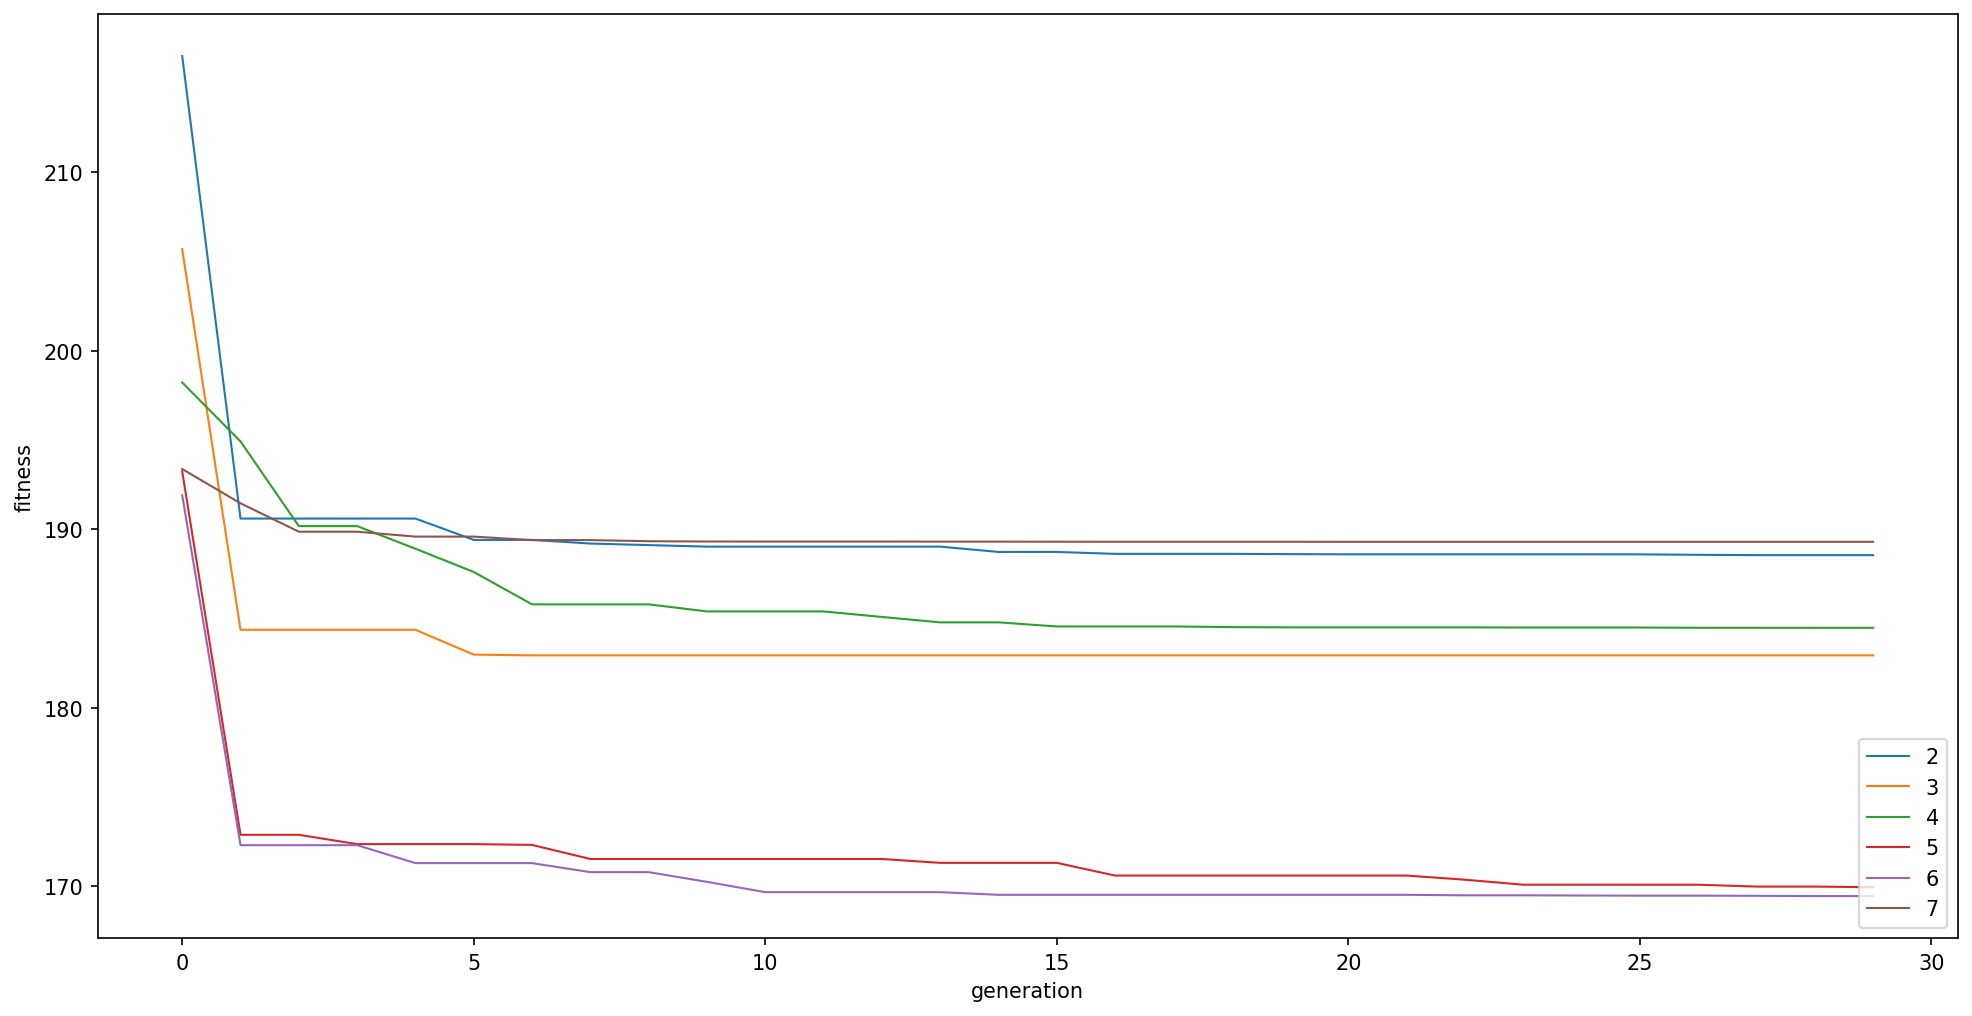

In [29]:
print("CMA-ES")
# Label each Z
labels          = [str(r[0])     for r in results_cmaes]
fitnesses_cmaes = np.array([r[3] for r in results_cmaes])
# create image with Z's as labels
create_history_fig(labels, fitnesses_cmaes)

OPENAI-ES


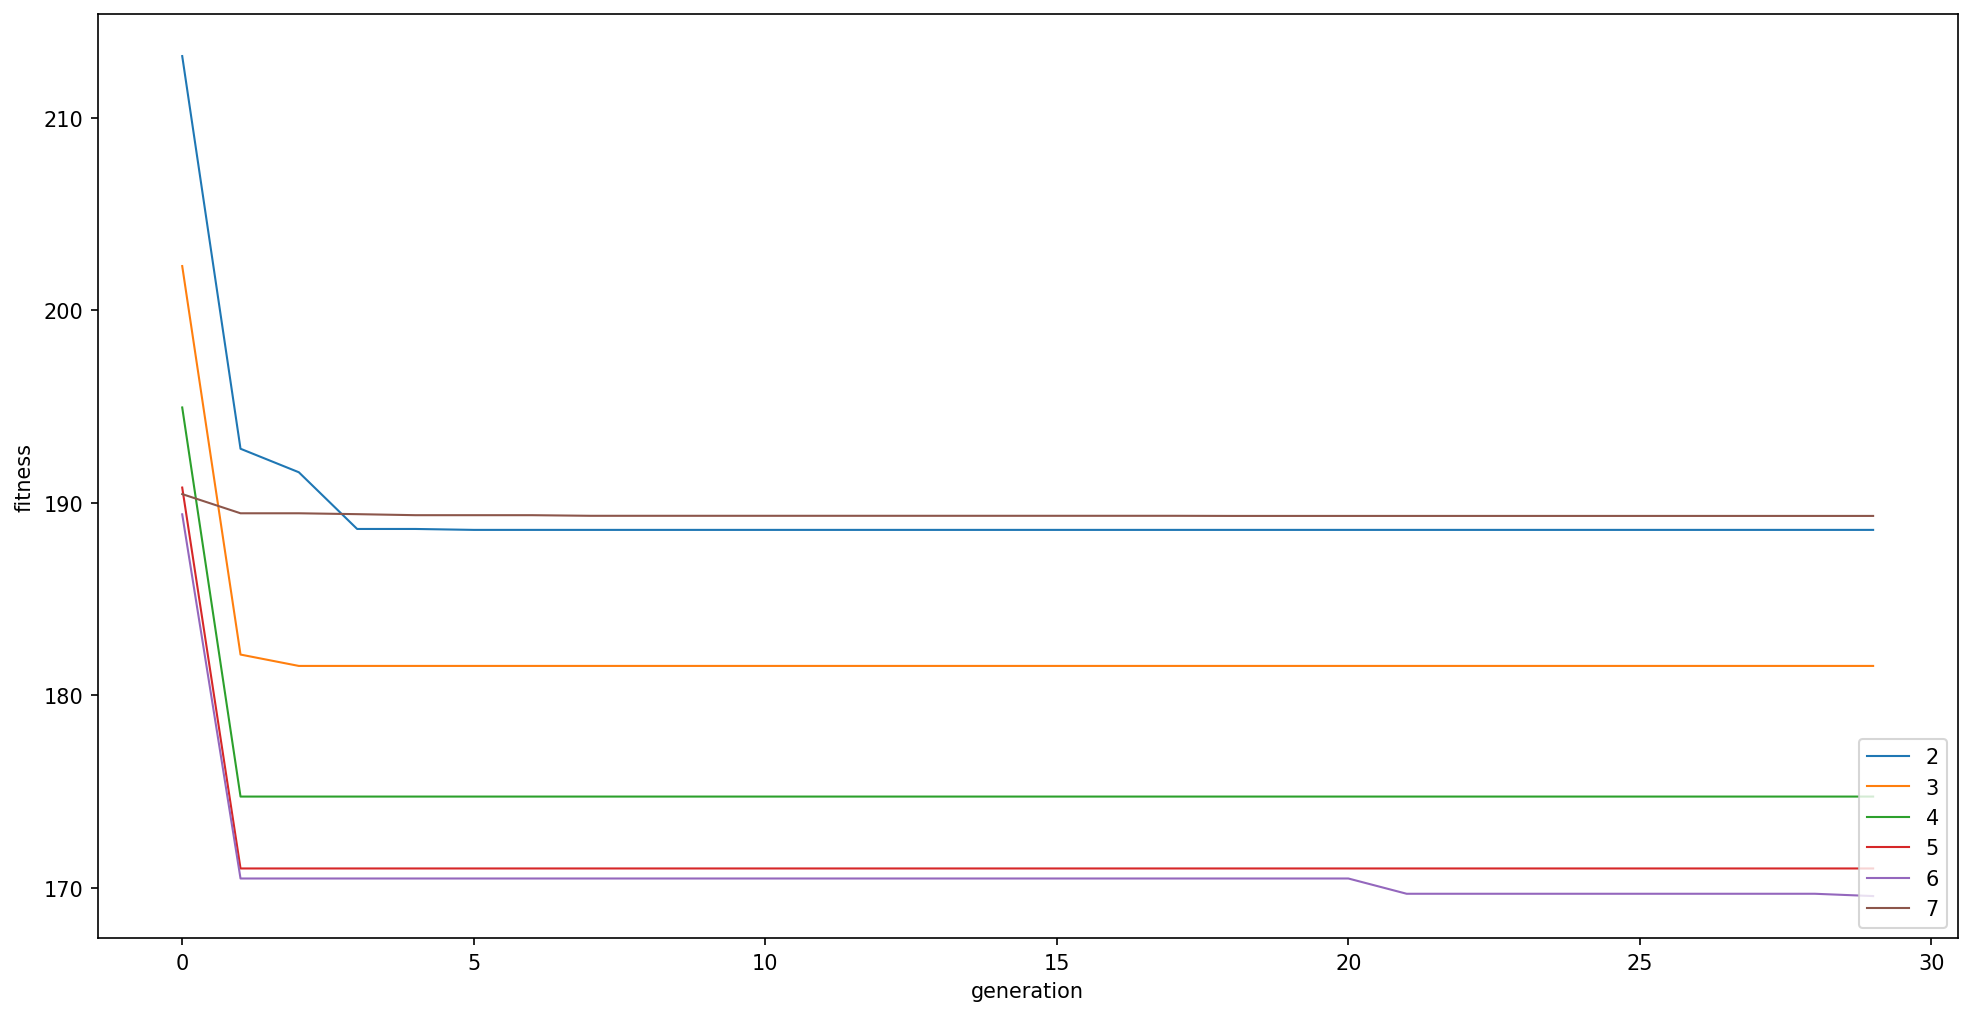

In [30]:
print("OPENAI-ES")
# Label each Z
labels             = [str(r[0])     for r in results_openaies]
fitnesses_openaies = np.array([r[3] for r in results_openaies])
# create image with Z's as labels
create_history_fig(labels, fitnesses_openaies)

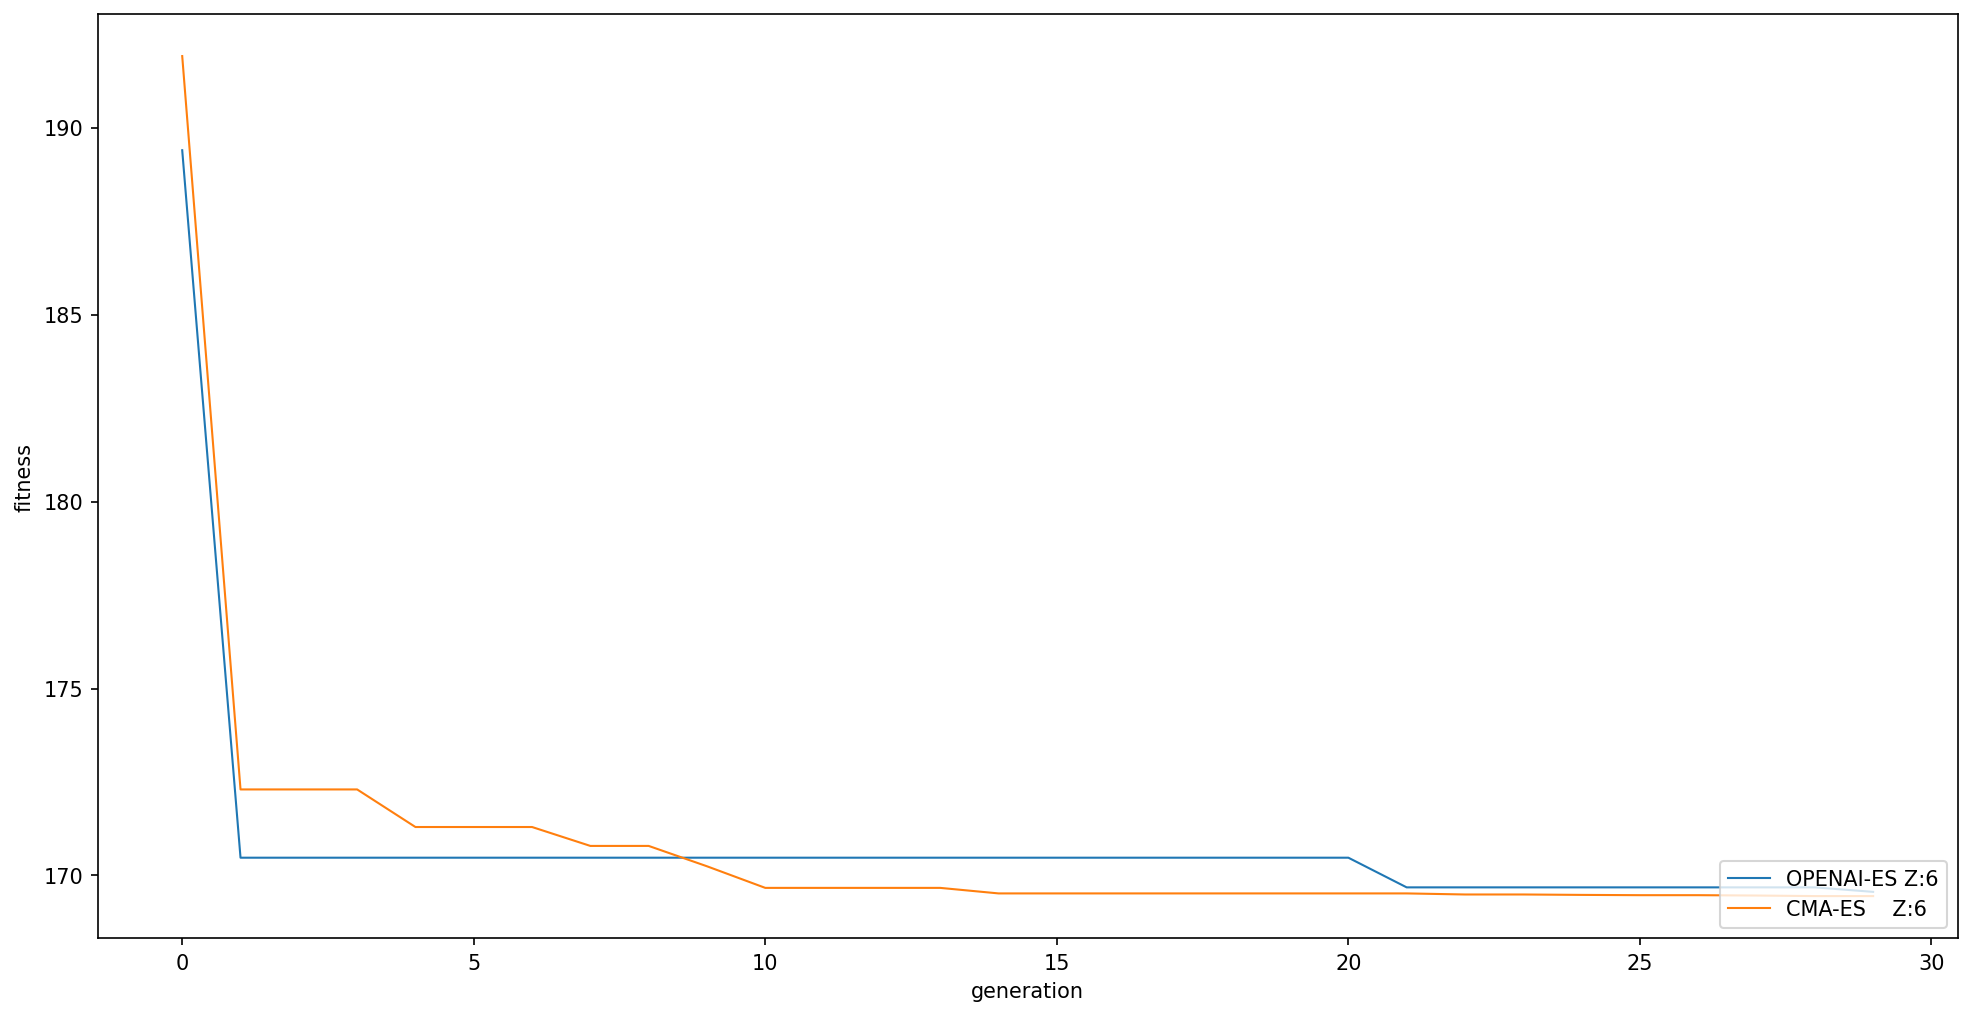

In [31]:
best_result_openaies = min(results_openaies, key=lambda r: -r[2])
best_result_cmaes    = min(results_cmaes,    key=lambda r: -r[2])

labels    = ['OPENAI-ES Z:'+str(best_result_openaies[0]),
             'CMA-ES    Z:'+str(best_result_cmaes[0])]
fitnesses = [np.array(best_result_openaies[3]), 
             np.array(best_result_cmaes[3])]
# create image with Z's as labels
create_history_fig(labels, fitnesses)